In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


我在看一下你那邊是做啥
隨機森林 類神經 決策樹

In [ ]:
#完整  XGBoost 使用lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)
#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)


####################################################
lasso = Lasso(alpha=0.1)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)


###################################################

# 3. 使用 GridSearchCV 調參並訓練 XGBoost 模型

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''
xgb = XGBClassifier(random_state=42)

#使用GridSearchCV: 1. 自動調參：不需要手動嘗試每個參數組合、2.交叉驗證：使用交叉驗證確保模型性能的穩定性。、3.最佳模型選擇：返回最佳參數下的模型。
grid_search = GridSearchCV(estimator=xgb,param_grid=param_grid,  cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
#執行GridSearchCV
grid_search.fit(X_train_selected, y_train)

# 獲取grid_search最佳模型
best_xgb_model = grid_search.best_estimator_

# 進行測試集評估
y_pred_test = best_xgb_model.predict(X_test_selected)
y_pred_prob = best_xgb_model.predict_proba(X_test_selected)  # 用於 AUC 計算

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
classification_rep = classification_report(y_test, y_pred_test)
print("Classification Report:\n", classification_rep)

# 特徵重要性分析
feature_importances = best_xgb_model.feature_importances_
important_features = pd.Series(feature_importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", important_features)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
<ipython-input-2-f005079942e7>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


selected_features Index(['power_capacity', 'storage_cap', 'device_mass', 'display_v',
       'display_h', 'memory_cap', 'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:31:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Accuracy: 0.8772
Precision: 0.8779
Recall (Sensitivity): 0.8772
F1-Score: 0.8773
AUC (ROC): 0.9810
AUC (PR): 0.9446
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       125
         1.0       0.88      0.84      0.86       136
         2.0       0.81      0.85      0.83       131
         3.0       0.91      0.90      0.91       129

    accuracy                           0.88       521
   macro avg       0.88      0.88      0.88       521
weighted avg       0.88      0.88      0.88       521

Feature Importances:
 memory_cap        0.498677
power_capacity    0.154188
display_v         0.121277
display_h         0.111681
pixel_density     0.044059
device_mass       0.040656
storage_cap       0.029461
dtype: float32


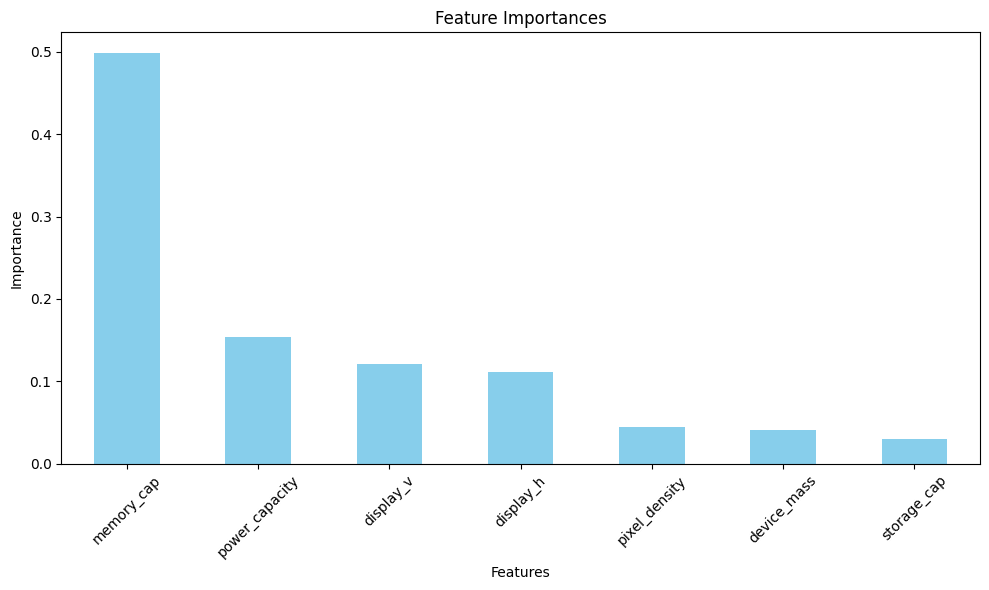

ExactExplainer explainer: 522it [03:01,  2.68it/s]


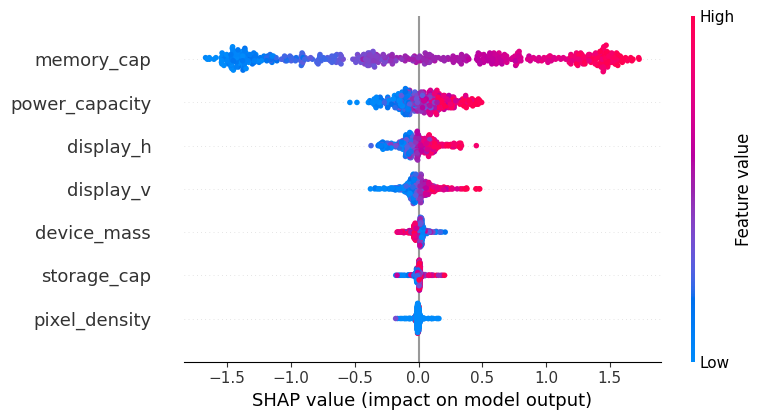

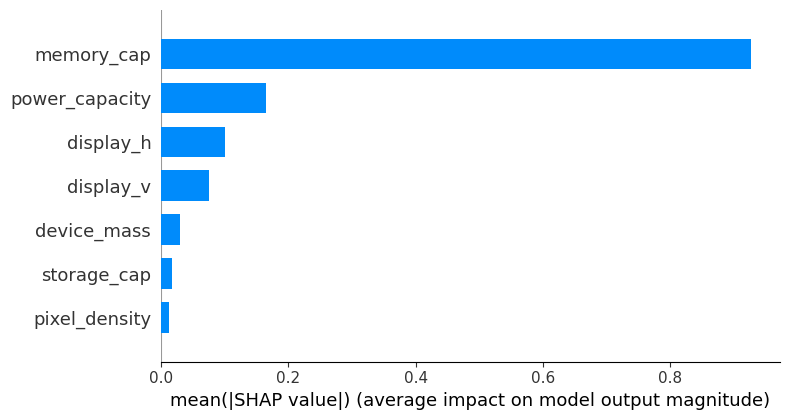

In [ ]:
# 繪製特徵重要性圖
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import shap
# 分析：SHAP 值解釋
explainer = shap.Explainer(best_xgb_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")





selected_features Index(['power_capacity', 'storage_cap', 'device_mass', 'display_v',
       'display_h', 'memory_cap', 'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-7-2c06d837f78e>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1459
[LightGBM] [Info] Number of data points in the train set: 1215, number of used features: 7
[LightGBM] [Info] Start training from score -1.369158
[LightGBM] [Info] Start training from score -1.425746
[LightGBM] [Info] Start training from score -1.359496
[LightGBM] [Info] Start training from score -1.392072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

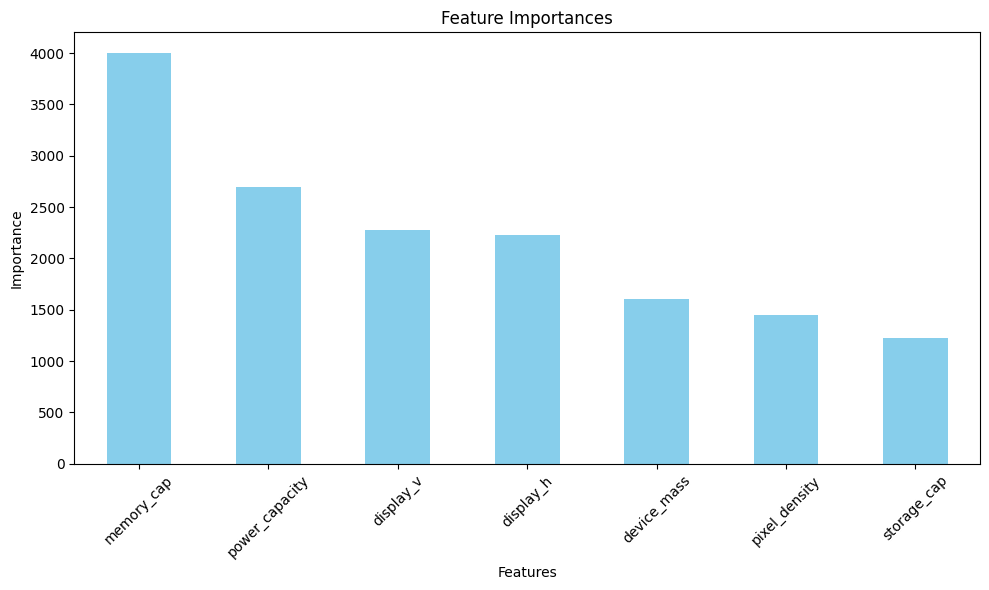

ExactExplainer explainer: 522it [16:40,  1.94s/it]


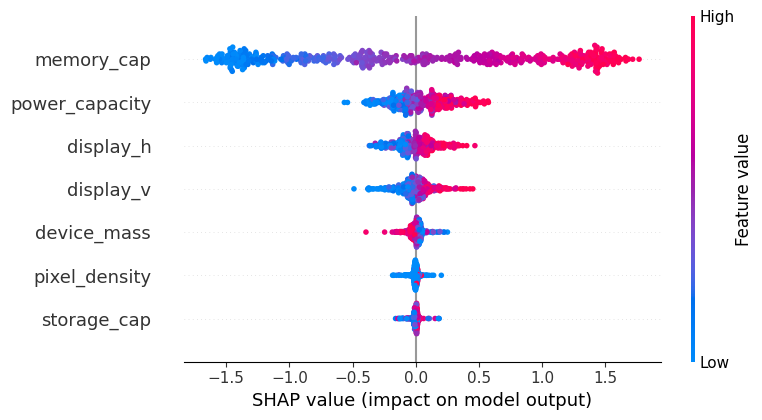

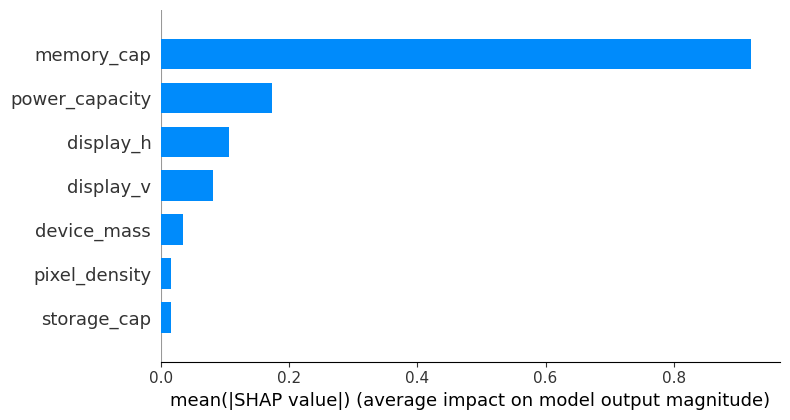

In [ ]:
#model 2: 改LightGBM 有lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)
#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)


####################################################
lasso = Lasso(alpha=0.1)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)




# 3. 使用 GridSearchCV 調參並訓練 XGBoost 模型
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''

###################################################

lgbm = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
#執行GridSearchCV
grid_search.fit(X_train_selected, y_train)

# 獲取grid_search最佳模型
best_lgbm_model = grid_search.best_estimator_

# 進行測試集評估
y_pred_test = best_lgbm_model.predict(X_test_selected)
y_pred_prob = best_lgbm_model.predict_proba(X_test_selected)  # 用於 AUC 計算

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("LightGBM 版本:")
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
classification_rep = classification_report(y_test, y_pred_test)
print("Classification Report:\n", classification_rep)

# 特徵重要性分析
feature_importances = best_lgbm_model.feature_importances_
important_features = pd.Series(feature_importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", important_features)
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 分析：SHAP 值解釋
explainer = shap.Explainer(best_lgbm_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")


In [ ]:
importance_gain = best_lgbm_model.booster_.feature_importance(importance_type='gain')
importances_gain = pd.Series(importance_gain, index=selected_features).sort_values(ascending=False)
print("Feature Importance (Gain):\n", importances_gain)

Feature Importance (Gain):
 memory_cap        6141.746576
power_capacity    1370.970823
display_v          700.085277
display_h          687.033352
device_mass        181.070507
pixel_density      147.554923
storage_cap        122.735403
dtype: float64


selected_features Index(['power_capacity', 'storage_cap', 'device_mass', 'display_v',
       'display_h', 'memory_cap', 'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-9-c2c04e3d4fef>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


CatBoost 版本:
Best Parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 4, 'learning_rate': 0.1}
Accuracy: 0.9117
Precision: 0.9115
Recall: 0.9117
F1-Score: 0.9116
AUC (ROC): 0.9881
AUC (PR): 0.9646
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       125
         1.0       0.88      0.87      0.87       136
         2.0       0.89      0.89      0.89       131
         3.0       0.95      0.96      0.96       129

    accuracy                           0.91       521
   macro avg       0.91      0.91      0.91       521
weighted avg       0.91      0.91      0.91       521

Feature Importances:
 memory_cap        62.023727
power_capacity    16.331757
display_h          8.824035
display_v          6.924495
device_mass        2.684919
pixel_density      1.822554
storage_cap        1.388513
dtype: float64


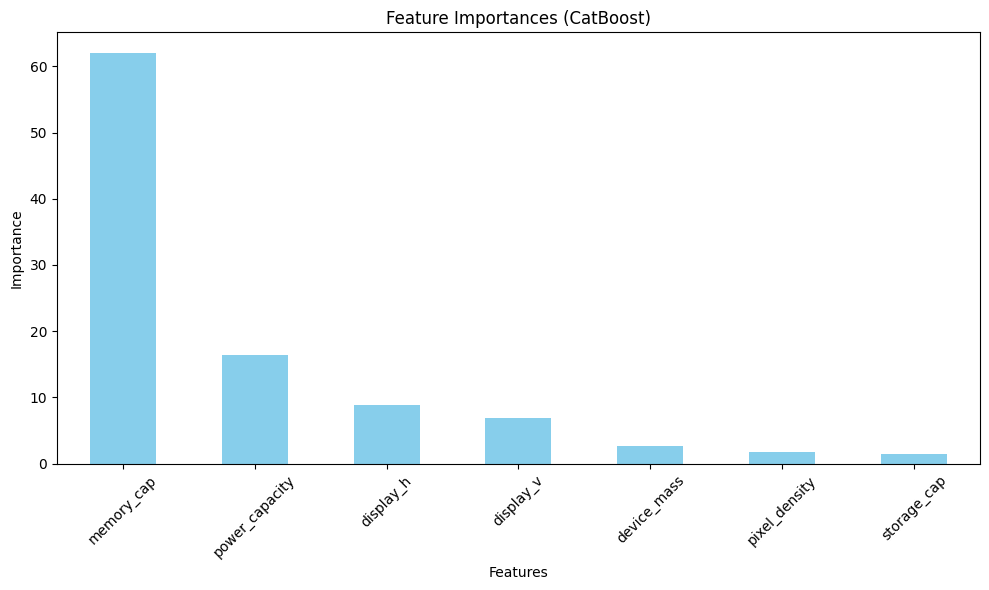

ExactExplainer explainer: 522it [00:16, 16.10it/s]                         


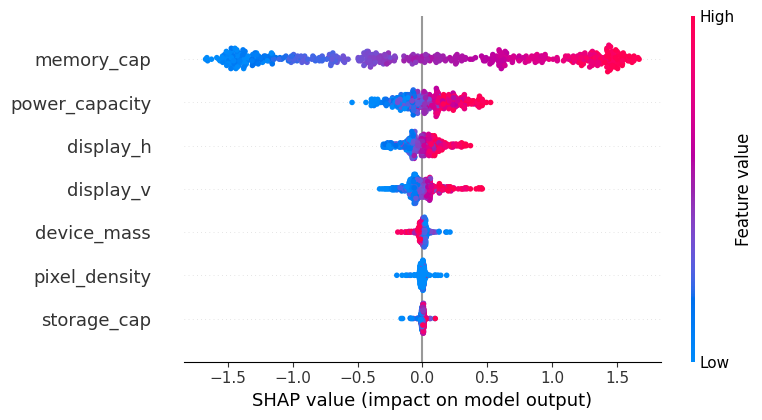

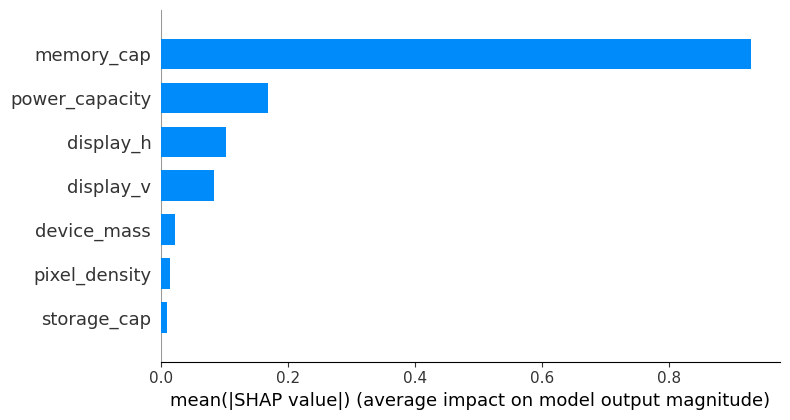

In [ ]:
#model 3: 改catboosting 有lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)
#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)


####################################################
lasso = Lasso(alpha=0.1)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)




# 3. 使用 GridSearchCV 調參並訓練 XGBoost 模型
param_grid= {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''

###################################################

catboost = CatBoostClassifier(random_state=42, verbose=0)
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_catboost_model = grid_search.best_estimator_
y_pred_test = best_catboost_model.predict(X_test_selected)
y_pred_prob = best_catboost_model.predict_proba(X_test_selected)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("CatBoost 版本:")
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# 特徵重要性分析
feature_importances = best_catboost_model.feature_importances_
important_features = pd.Series(feature_importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", important_features)


plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances (CatBoost)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 分析：SHAP 值解釋
explainer = shap.Explainer(best_catboost_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")


selected_features Index(['power_capacity', 'storage_cap', 'device_mass', 'display_v',
       'display_h', 'memory_cap', 'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-10-8ceb794fb76f>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


Gradient Boosting 版本:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.8618
Precision: 0.8618
Recall: 0.8618
F1-Score: 0.8618
AUC (ROC): 0.9766
AUC (PR): 0.9297
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       125
         1.0       0.81      0.81      0.81       136
         2.0       0.80      0.81      0.81       131
         3.0       0.92      0.92      0.92       129

    accuracy                           0.86       521
   macro avg       0.86      0.86      0.86       521
weighted avg       0.86      0.86      0.86       521

Feature Importances:
 memory_cap        0.765736
power_capacity    0.129470
display_v         0.056667
display_h         0.028540
device_mass       0.008158
pixel_density     0.008004
storage_cap       0.003424
dtype: float64


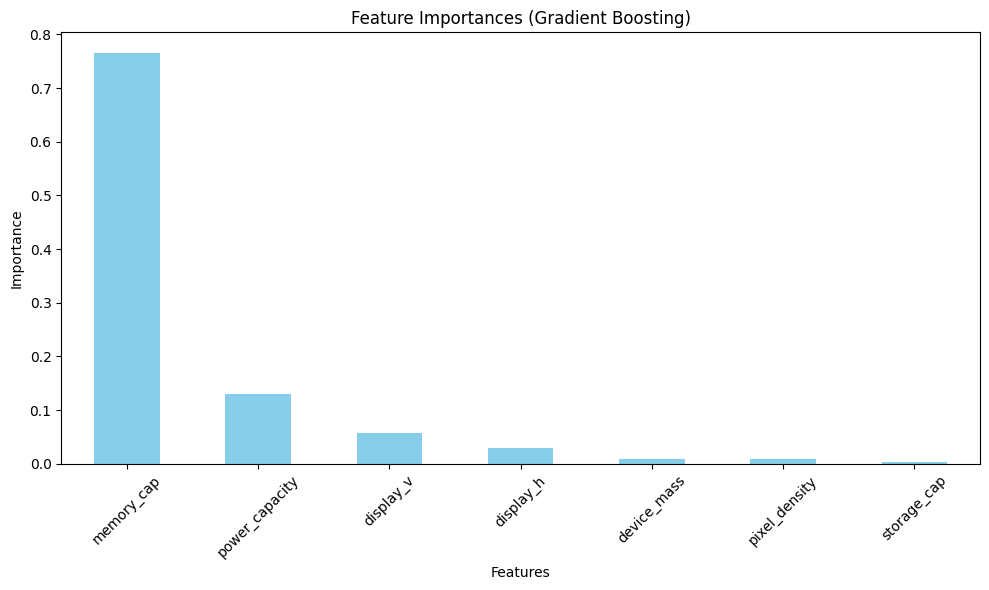

ExactExplainer explainer: 522it [00:34, 10.69it/s]                         


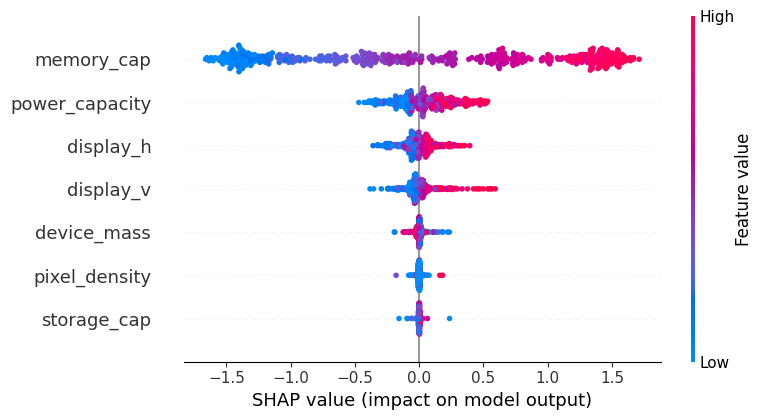

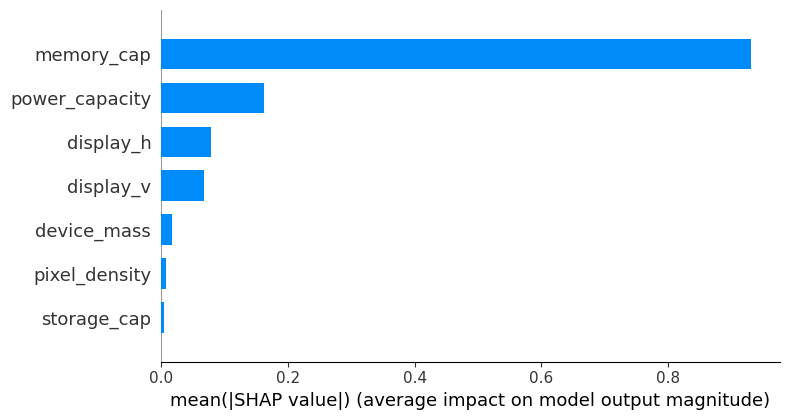

In [ ]:
#model 4: 改gradient boosting 有lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)
#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)


####################################################
lasso = Lasso(alpha=0.1)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)


# 3. 使用 GridSearchCV 調參並訓練 XGBoost 模型
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''

###################################################

gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_gb_model  = grid_search.best_estimator_
y_pred_test = best_gb_model.predict(X_test_selected)
y_pred_prob = best_gb_model.predict_proba(X_test_selected)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("Gradient Boosting 版本:")
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# 特徵重要性分析
feature_importances = best_gb_model.feature_importances_
important_features = pd.Series(feature_importances, index=selected_features).sort_values(ascending=False)
print("Feature Importances:\n", important_features)


plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances (Gradient Boosting)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 分析：SHAP 值解釋
explainer = shap.Explainer(best_gb_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")


<ipython-input-17-ee4af1917b09>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


selected_features Index(['power_capacity', 'bluetooth', 'processor_freq', 'multi_card_slots',
       'frontcam_res', '5g', 'storage_cap', 'chassis_z', 'device_mass',
       'cpu_units', 'maincam_res', 'display_v', 'display_h', 'memory_cap',
       'panel_height', 'panel_width', 'operation_time', '4g',
       'multi_point_touch', 'wifi6', 'pixel_density'],
      dtype='object')
Fitting 3 folds for each of 45 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression 版本: 
Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
Accuracy: 0.8253
Precision: 0.8193
Recall: 0.8253
F1-Score: 0.8203
AUC (ROC): 0.9467
AUC (PR): 0.8608
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       125
         1.0       0.77      0.68      0.72       136
         2.0       0.75      0.69      0.72       131
         3.0       0.88      0.98      0.93       129

    accuracy                           0.83       521
   macro avg       0.82      0.83      0.82       521
weighted avg       0.82      0.83      0.82       521

Feature Importances (Logistic Regression coefficients):
 device_mass          0.290453
5g                   0.207260
wifi6                0.181584
cpu_units            0.155125
multi_card_slots     0.115278
multi_point_touch    0.108348
processor_freq       0.104243
pixel_density        0.068951
bluetooth            0.058426
panel_width          0.0

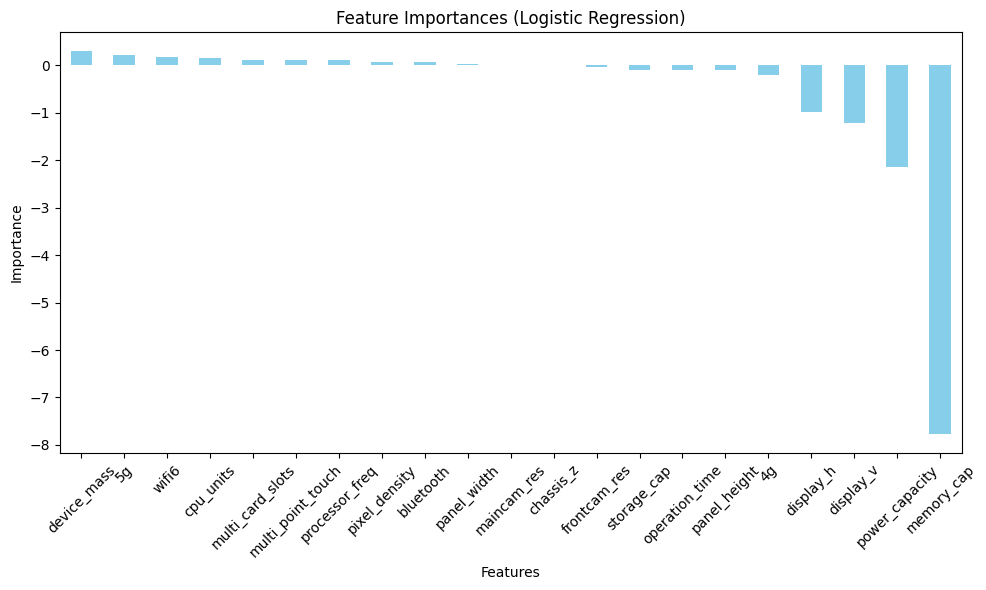

PermutationExplainer explainer: 522it [00:30, 11.42it/s]                         


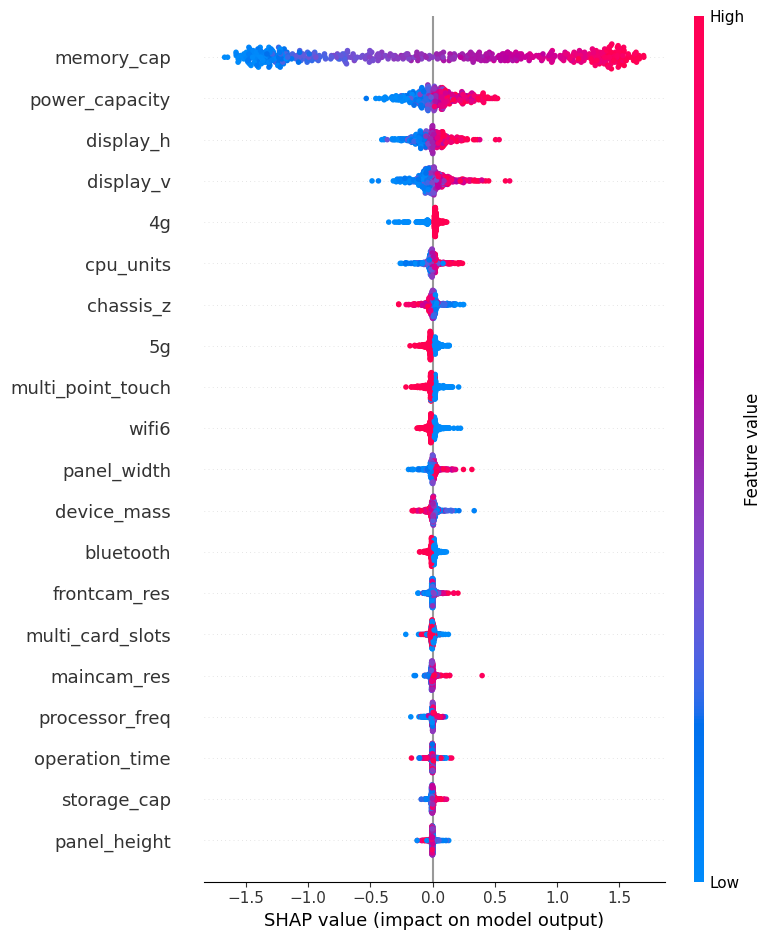

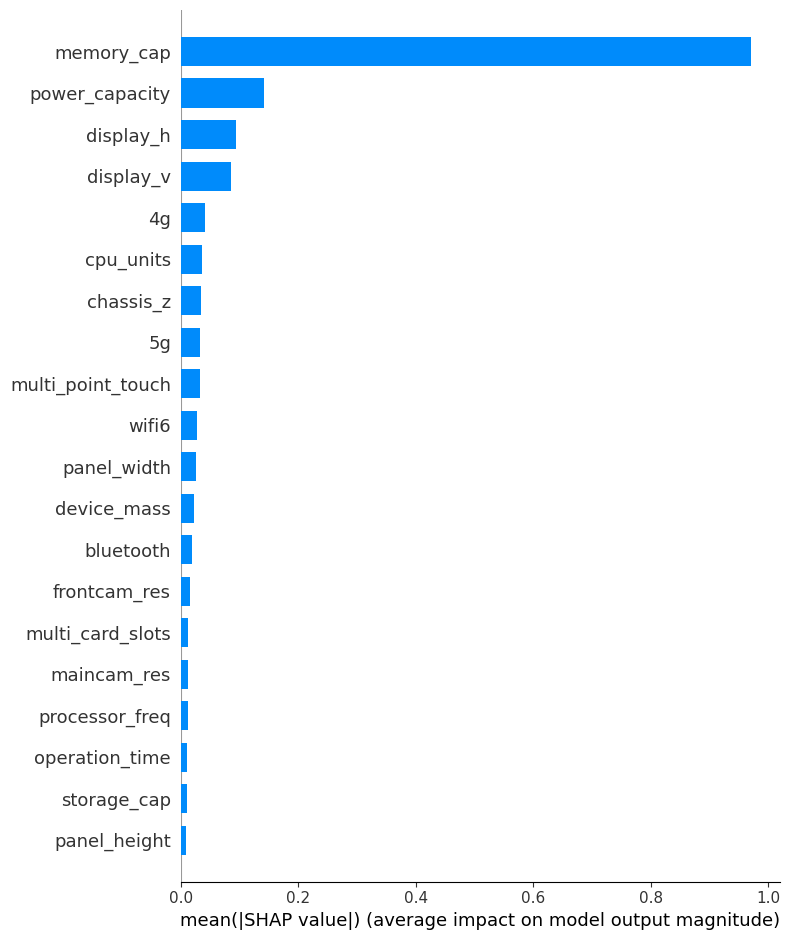

In [ ]:
#model 5: 改Logistic Regression 有lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve

#五種
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel('dataset.xlsx')
df_copy = df.copy()
target_variable = 'market_segment'

##########################################################
#資料處理
'''
continuous_features = [
    'power_capacity', 'processor_freq', 'frontcam_res', 'storage_cap',
    'chassis_z', 'device_mass', 'cpu_units', 'maincam_res',
    'display_v', 'display_h', 'memory_cap', 'panel_height',
    'panel_width', 'operation_time'
]
binary_features = ['bluetooth', 'multi_card_slots', '5g', '4g', 'multi_point_touch', 'wifi6']
'''
#預處理1: 移除沒有目標變數的項目
df_copy.dropna(subset=[target_variable], inplace=True)
#預處理2: 用中位數補零
for col in df_copy.columns:
    if col != target_variable and pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
#預處理3: 1th-99th
for col in df_copy.select_dtypes(include=np.number):
    if col != target_variable:
        p1 = np.percentile(df_copy[col], 1)
        p99 = np.percentile(df_copy[col], 99)
        df_copy[col] = np.clip(df_copy[col], p1, p99)

#預處理4: 分訓練集&測試集7:3
train_df, test_df = train_test_split(df_copy, test_size=0.3, random_state=42)
#預處理5: 增加一個特徵：「像素密度」= ( display_v * display_h ) / (panel_height * panel_width)，再以Lasso回歸選擇特徵並分別以決策樹、隨機森林及類神經網路建模。決策樹的模型設定上，使用GridSearchCV，GridSearchCV param_grid = { 'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None] }用決策數建模後，分別對test_df進行預測，並計算評估指標(精確度、F1-Score)
for df in [train_df, test_df]:
    if {'display_v', 'display_h', 'panel_height', 'panel_width'}.issubset(df.columns):
        df['pixel_density'] = (df['display_v'] * df['display_h']) / (df['panel_height'] * df['panel_width']).replace(0,1e-6)
#預處理6: GridSearchCV，分離特徵和目標變數：將 market_segment 作為目標變數，其餘為特徵。
X_train = train_df.drop('market_segment', axis=1)
y_train = train_df['market_segment']
X_test = test_df.drop('market_segment', axis=1)
y_test = test_df['market_segment']
#預處理7(貌似無必要): 將目標變數 y_train 和 y_test（即 market_segment）從文字或類別型數據轉換成數字標籤，以便機器學習模型可以處理。
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)

#add 連續變數標準化
# 2. 標準化連續變數
scaler = StandardScaler()
continuous_features = X_train.select_dtypes(include=np.number).columns
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])



####################################################
lasso = Lasso(alpha=0.0000001)  # You might need to tune alpha
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("selected_features",selected_features)


param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 正則化強度的倒數
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

'''
初始化了一個 XGBoost 分類器，即 XGBClassifier，並設置了一些特定參數
1.random_state=42 ->固定隨機種子以保證結果的可重現性。在每次執行中，隨機過程（如樣本選擇）會產生相同的結果。
2.use_label_encoder=False -> 從 XGBoost 1.3 版開始，為了與 Scikit-learn 接軌，XGBoost 支援直接處理數字標籤。設置為 False，表示不再使用內建的 LabelEncoder，而是依賴外部的編碼（如 Scikit-learn 的 LabelEncoder）。
3.eval_metric='logloss' ->設定評估指標為對數損失（logarithmic loss）。適用於多分類和二分類問題。該指標衡量預測的機率分佈與真實分佈的接近程度。
'''

###################################################

lr = LogisticRegression(random_state=42, multi_class='ovr')
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_lr_model   = grid_search.best_estimator_
y_pred_test = best_lr_model.predict(X_test_selected)
y_pred_prob = best_lr_model.predict_proba(X_test_selected)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # ROC AUC
pr_auc = average_precision_score(y_test, y_pred_prob, average='weighted')  # PR AUC

# 打印結果
print("Logistic Regression 版本: ")
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC (ROC): {roc_auc:.4f}")
print(f"AUC (PR): {pr_auc:.4f}")
#分類報告
print("Classification Report:\n", classification_report(y_test, y_pred_test))

#特徵重要性分析 (基於係數)
coefficients = best_lr_model.coef_[0]  # 取得 Logistic Regression 的係數
important_features = pd.Series(coefficients, index=selected_features).sort_values(ascending=False)
print("Feature Importances (Logistic Regression coefficients):\n", important_features)


plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.title('Feature Importances (Logistic Regression)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 分析：SHAP 值解釋
explainer = shap.Explainer(best_lr_model.predict, X_test_selected)
shap_values = explainer(X_test_selected)
# 可視化 SHAP 值
shap.summary_plot(shap_values, X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")

